## 初期設定

In [4]:
exp_name = '9045_Stacking' # ファイル名とそろえる

In [5]:
import os, gc, json
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm.callback import early_stopping
import seaborn as sns

# モデル名とデータフォルダの定義
models = [
    '8274_Effnetb0TorchV',
    '8284_Effnetb1TorchV',
    '8292_Effnetb2TorchV',
    '8295_Effnetv2sTorchV',
    '8288_MaxVitTinyTimm',
    '8295_MobileNetV4HybMTimm',
    
    '8304_Effnetb0TorchV',
    '8314_Effnetb1TorchV',
    '8316_Effnetb2TorchV',
    '8313_Effnetv2sTorchV',
    '8299_MaxVitTinyTimm',
    '8317_MobileNetV4HybMTimm',

    '8322_Effnetb0TorchV',
    '8323_Effnetb2TorchV'
]

output_folder = 'output/'

# ユーザーIDのリスト
user_ids = ['0001', '0002', '0003', '0004', '0005']

alpha = 0.001

In [6]:
output_folder = "output/"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)

## 1データ確認

In [7]:
# ユーザーごとに処理
user_id = "0001"
train_features = []
test_features = []
train_true_values = None

# 各モデルのデータを結合
for model in models:
    train_path = f"{output_folder}/{model}/train_{user_id}.csv"
    test_path = f"{output_folder}/{model}/test_{user_id}.csv"
    
    # 訓練データの読み込み
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # 予測値のみ抽出し、列名にモデル名を追加
    model_prefix = model[:10]  # モデル名の最初の10文字
    train_predicted = train_data.filter(regex='_predicted').rename(columns=lambda x: f"{model_prefix}_{x}")
    test_predicted = test_data.filter(regex='_predicted').rename(columns=lambda x: f"{model_prefix}_{x}")
    
    train_features.append(train_predicted)
    test_features.append(test_predicted)
    
    # 真値を保存
    if train_true_values is None:
        train_true_values = train_data[['vel_x', 'vel_y', 'vel_z']]

# 特徴量を結合
train_features = pd.concat(train_features, axis=1)
test_features = pd.concat(test_features, axis=1)


In [8]:
train_features

,8274_Effne_vel_x_predicted,8274_Effne_vel_y_predicted,8274_Effne_vel_z_predicted,8284_Effne_vel_x_predicted,8284_Effne_vel_y_predicted,8284_Effne_vel_z_predicted,8292_Effne_vel_x_predicted,8292_Effne_vel_y_predicted,8292_Effne_vel_z_predicted,8295_Effne_vel_x_predicted,...,8299_MaxVi_vel_z_predicted,8317_Mobil_vel_x_predicted,8317_Mobil_vel_y_predicted,8317_Mobil_vel_z_predicted,8322_Effne_vel_x_predicted,8322_Effne_vel_y_predicted,8322_Effne_vel_z_predicted,8323_Effne_vel_x_predicted,8323_Effne_vel_y_predicted,8323_Effne_vel_z_predicted
0,-0.197864,-0.017792,-0.386197,0.093082,0.033738,-0.411484,-0.059319,-0.098331,-0.287037,0.154527,...,-0.327675,0.021125,-0.011131,-0.416885,-0.167660,-0.186281,-0.707634,0.193122,-0.101572,-0.301212
1,-0.272239,-0.058855,-0.501362,0.040189,0.007395,-0.519210,-0.122077,-0.129289,-0.381121,0.073554,...,-0.450187,-0.026249,-0.053619,-0.521628,-0.231058,-0.198660,-0.809982,0.125167,-0.118252,-0.403822
2,-0.339819,-0.109694,-0.613076,-0.023583,-0.019580,-0.623805,-0.187056,-0.161713,-0.470115,-0.014435,...,-0.567642,-0.122906,-0.064072,-0.644726,-0.299267,-0.215535,-0.906445,0.049078,-0.140301,-0.508277
3,-0.411764,-0.152737,-0.715452,-0.095406,-0.052620,-0.724496,-0.257102,-0.197591,-0.553807,-0.098978,...,-0.675288,-0.177804,-0.112816,-0.727675,-0.375974,-0.236928,-1.000433,-0.034549,-0.164413,-0.606888
4,-0.489489,-0.196113,-0.815039,-0.175144,-0.089362,-0.821276,-0.334149,-0.235099,-0.632639,-0.181229,...,-0.760851,-0.288938,-0.133901,-0.843171,-0.459188,-0.266624,-1.088840,-0.129554,-0.190430,-0.702794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,3.235661,0.926746,-0.207045,3.168457,1.157342,-0.199474,2.958690,1.286549,-0.098909,3.026916,...,-0.198783,3.065087,1.181311,-0.287665,3.238094,0.808108,-0.230474,3.049167,1.101897,-0.142764
9566,3.248221,0.935655,-0.228563,3.147325,1.156508,-0.217735,2.960028,1.303555,-0.129441,3.016904,...,-0.224694,3.071634,1.204886,-0.292237,3.238749,0.800088,-0.238061,3.055014,1.095733,-0.163845
9567,3.264560,0.945228,-0.243367,3.120755,1.152661,-0.230649,2.967007,1.316535,-0.154356,3.008742,...,-0.235276,3.074203,1.202060,-0.284850,3.235105,0.789324,-0.240645,3.058330,1.092257,-0.181295
9568,3.284186,0.954898,-0.252380,3.093924,1.145583,-0.233534,2.974653,1.331348,-0.173246,3.000585,...,-0.236022,3.088598,1.216851,-0.261836,3.229108,0.777769,-0.238992,3.063088,1.082837,-0.194561


In [9]:
test_features

,8274_Effne_vel_x_predicted,8274_Effne_vel_y_predicted,8274_Effne_vel_z_predicted,8284_Effne_vel_x_predicted,8284_Effne_vel_y_predicted,8284_Effne_vel_z_predicted,8292_Effne_vel_x_predicted,8292_Effne_vel_y_predicted,8292_Effne_vel_z_predicted,8295_Effne_vel_x_predicted,...,8299_MaxVi_vel_z_predicted,8317_Mobil_vel_x_predicted,8317_Mobil_vel_y_predicted,8317_Mobil_vel_z_predicted,8322_Effne_vel_x_predicted,8322_Effne_vel_y_predicted,8322_Effne_vel_z_predicted,8323_Effne_vel_x_predicted,8323_Effne_vel_y_predicted,8323_Effne_vel_z_predicted
0,0.147148,0.274679,-0.682924,0.094233,0.234786,-0.729101,0.150146,0.240779,-0.749567,0.081575,...,-0.945374,0.172970,0.249363,-0.750749,0.101081,0.145397,-0.737648,0.146905,0.271472,-0.742719
1,0.207195,0.303236,-0.791340,0.158578,0.261108,-0.830989,0.208238,0.276592,-0.852678,0.151445,...,-1.046903,0.236626,0.284154,-0.858346,0.173140,0.164876,-0.818097,0.216242,0.302570,-0.832022
2,0.268022,0.333547,-0.896164,0.225980,0.289465,-0.926756,0.269578,0.314838,-0.952176,0.225247,...,-1.132700,0.299551,0.309421,-0.931173,0.245209,0.190934,-0.892364,0.287493,0.336622,-0.919463
3,0.333530,0.368155,-0.994011,0.296142,0.321486,-1.019572,0.337070,0.357414,-1.046682,0.302927,...,-1.214788,0.371018,0.347279,-1.019718,0.323772,0.221262,-0.966356,0.363212,0.373887,-1.003315
4,0.406188,0.407061,-1.085972,0.379333,0.355424,-1.107775,0.412124,0.404614,-1.135785,0.384182,...,-1.304833,0.436354,0.397617,-1.108789,0.406038,0.259831,-1.039583,0.446528,0.416559,-1.084583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9565,-2.627461,-1.093300,0.661588,-2.629821,-1.118316,0.462581,-2.593697,-0.996281,0.653334,-2.595701,...,0.649514,-2.605598,-1.196617,0.591633,-2.602492,-1.261833,0.418763,-2.702828,-1.035851,0.279888
9566,-2.567022,-1.072408,0.769383,-2.577350,-1.108607,0.554121,-2.528371,-0.971566,0.763669,-2.543396,...,0.745187,-2.544368,-1.193290,0.698691,-2.550040,-1.244452,0.504232,-2.651331,-1.019610,0.349037
9567,-2.497909,-1.050391,0.872100,-2.514235,-1.095290,0.641660,-2.454392,-0.945079,0.870490,-2.482861,...,0.861119,-2.477863,-1.176369,0.806465,-2.493946,-1.223345,0.591830,-2.593867,-0.999324,0.423264
9568,-2.420713,-1.024174,0.970273,-2.444624,-1.076316,0.729890,-2.372013,-0.916077,0.973302,-2.412233,...,0.963909,-2.401365,-1.156993,0.913899,-2.432342,-1.202198,0.678504,-2.533678,-0.978793,0.502233


In [10]:
train_true_values

,vel_x,vel_y,vel_z
0,0.193272,0.122026,-0.258740
1,0.119459,0.106136,-0.365619
2,0.043996,0.086143,-0.463906
3,-0.032592,0.058638,-0.558836
4,-0.122659,0.029072,-0.652777
...,...,...,...
9565,2.802231,1.706343,-0.229172
9566,2.791485,1.704184,-0.246656
9567,2.790000,1.704662,-0.256609
9568,2.792581,1.705046,-0.259632


## 全データ一括処理

feature_names:['8274_Effne_vel_x_predicted', '8284_Effne_vel_x_predicted', '8292_Effne_vel_x_predicted', '8295_Effne_vel_x_predicted', '8288_MaxVi_vel_x_predicted', '8295_Mobil_vel_x_predicted', '8304_Effne_vel_x_predicted', '8314_Effne_vel_x_predicted', '8316_Effne_vel_x_predicted', '8313_Effne_vel_x_predicted', '8299_MaxVi_vel_x_predicted', '8317_Mobil_vel_x_predicted', '8322_Effne_vel_x_predicted', '8323_Effne_vel_x_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+02, tolerance: 3.368e+00
  model = cd_fast.enet_coordinate_descent(


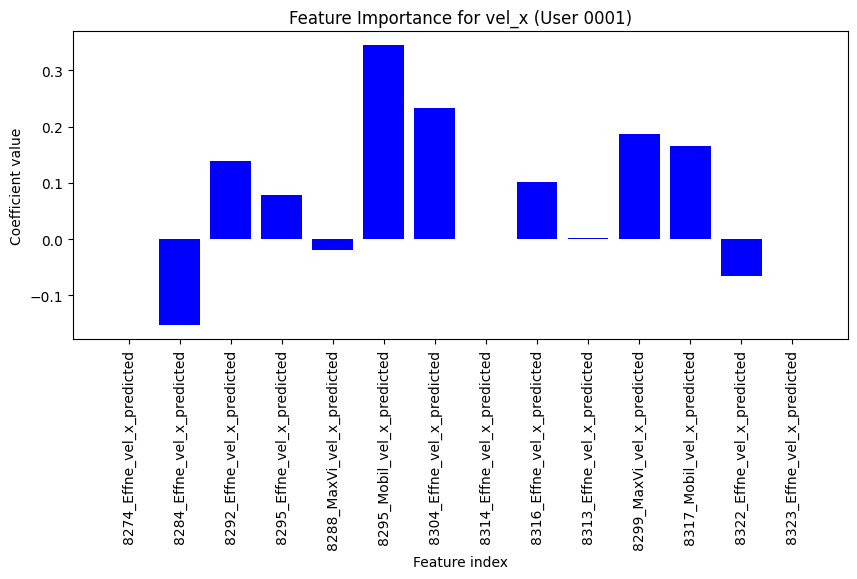

feature_names:['8274_Effne_vel_y_predicted', '8284_Effne_vel_y_predicted', '8292_Effne_vel_y_predicted', '8295_Effne_vel_y_predicted', '8288_MaxVi_vel_y_predicted', '8295_Mobil_vel_y_predicted', '8304_Effne_vel_y_predicted', '8314_Effne_vel_y_predicted', '8316_Effne_vel_y_predicted', '8313_Effne_vel_y_predicted', '8299_MaxVi_vel_y_predicted', '8317_Mobil_vel_y_predicted', '8322_Effne_vel_y_predicted', '8323_Effne_vel_y_predicted']


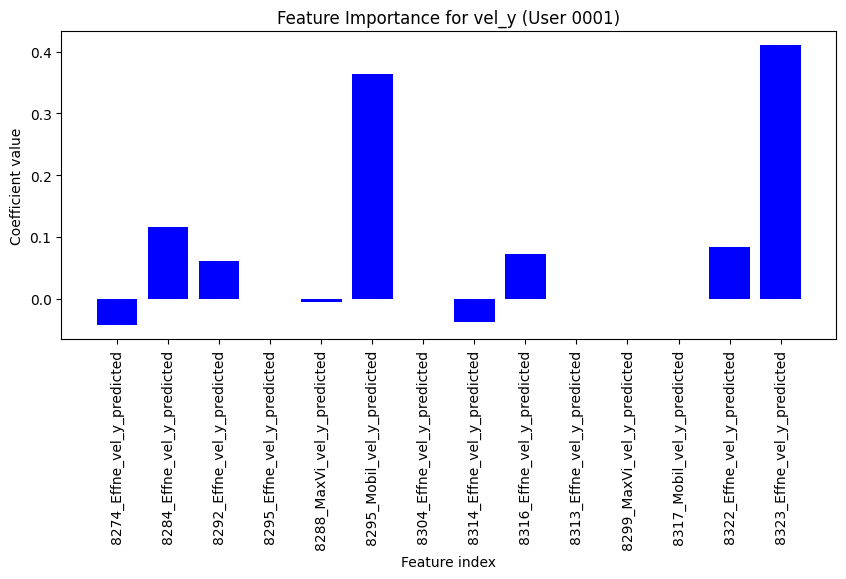

feature_names:['8274_Effne_vel_z_predicted', '8284_Effne_vel_z_predicted', '8292_Effne_vel_z_predicted', '8295_Effne_vel_z_predicted', '8288_MaxVi_vel_z_predicted', '8295_Mobil_vel_z_predicted', '8304_Effne_vel_z_predicted', '8314_Effne_vel_z_predicted', '8316_Effne_vel_z_predicted', '8313_Effne_vel_z_predicted', '8299_MaxVi_vel_z_predicted', '8317_Mobil_vel_z_predicted', '8322_Effne_vel_z_predicted', '8323_Effne_vel_z_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.529e-01, tolerance: 5.810e-01
  model = cd_fast.enet_coordinate_descent(


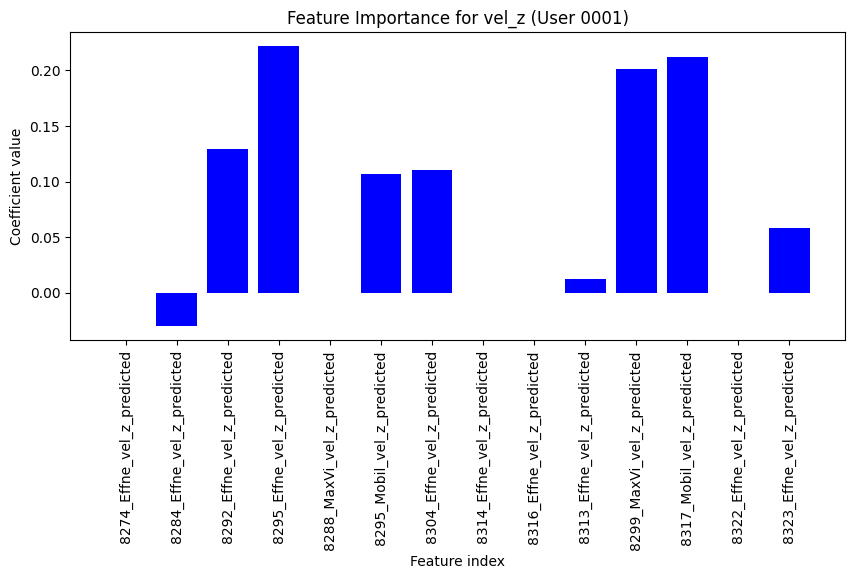

feature_names:['8274_Effne_vel_x_predicted', '8284_Effne_vel_x_predicted', '8292_Effne_vel_x_predicted', '8295_Effne_vel_x_predicted', '8288_MaxVi_vel_x_predicted', '8295_Mobil_vel_x_predicted', '8304_Effne_vel_x_predicted', '8314_Effne_vel_x_predicted', '8316_Effne_vel_x_predicted', '8313_Effne_vel_x_predicted', '8299_MaxVi_vel_x_predicted', '8317_Mobil_vel_x_predicted', '8322_Effne_vel_x_predicted', '8323_Effne_vel_x_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.751e+01, tolerance: 2.951e+00
  model = cd_fast.enet_coordinate_descent(


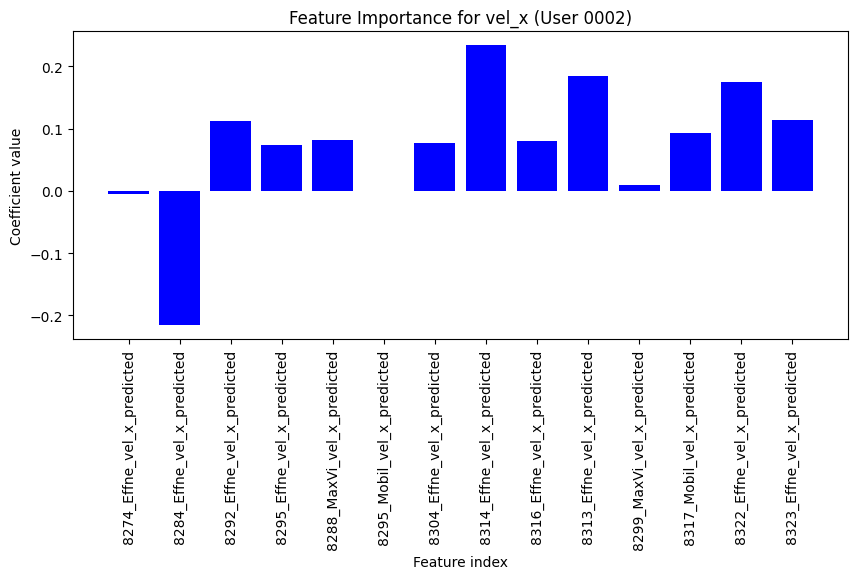

feature_names:['8274_Effne_vel_y_predicted', '8284_Effne_vel_y_predicted', '8292_Effne_vel_y_predicted', '8295_Effne_vel_y_predicted', '8288_MaxVi_vel_y_predicted', '8295_Mobil_vel_y_predicted', '8304_Effne_vel_y_predicted', '8314_Effne_vel_y_predicted', '8316_Effne_vel_y_predicted', '8313_Effne_vel_y_predicted', '8299_MaxVi_vel_y_predicted', '8317_Mobil_vel_y_predicted', '8322_Effne_vel_y_predicted', '8323_Effne_vel_y_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e+00, tolerance: 5.461e-01
  model = cd_fast.enet_coordinate_descent(


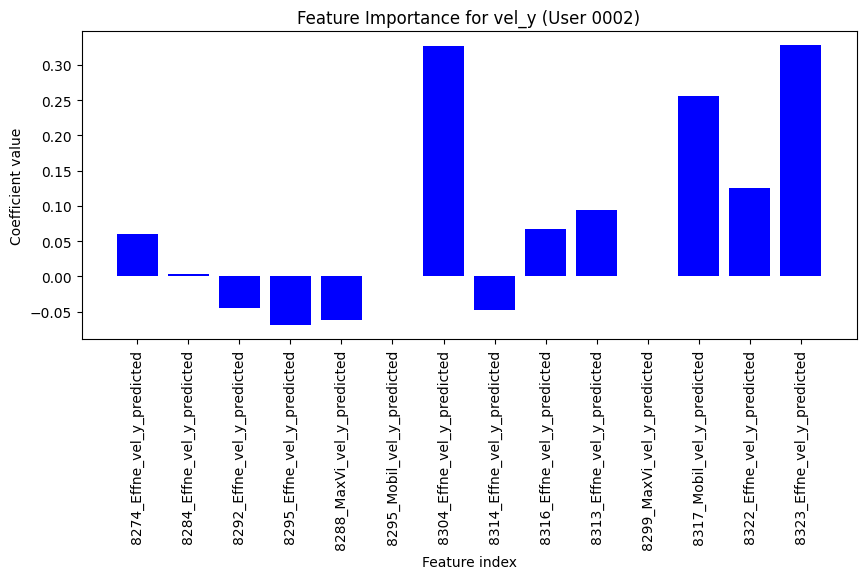

feature_names:['8274_Effne_vel_z_predicted', '8284_Effne_vel_z_predicted', '8292_Effne_vel_z_predicted', '8295_Effne_vel_z_predicted', '8288_MaxVi_vel_z_predicted', '8295_Mobil_vel_z_predicted', '8304_Effne_vel_z_predicted', '8314_Effne_vel_z_predicted', '8316_Effne_vel_z_predicted', '8313_Effne_vel_z_predicted', '8299_MaxVi_vel_z_predicted', '8317_Mobil_vel_z_predicted', '8322_Effne_vel_z_predicted', '8323_Effne_vel_z_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e+00, tolerance: 5.557e-01
  model = cd_fast.enet_coordinate_descent(


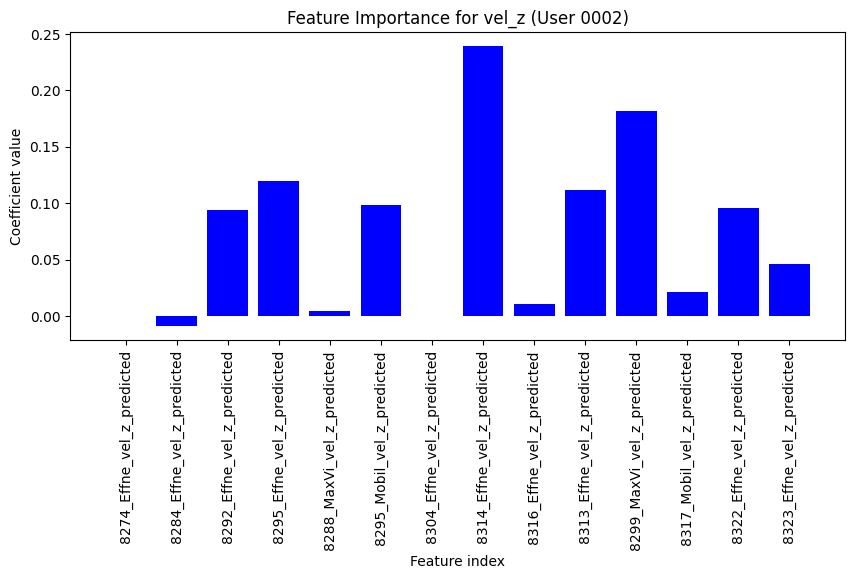

feature_names:['8274_Effne_vel_x_predicted', '8284_Effne_vel_x_predicted', '8292_Effne_vel_x_predicted', '8295_Effne_vel_x_predicted', '8288_MaxVi_vel_x_predicted', '8295_Mobil_vel_x_predicted', '8304_Effne_vel_x_predicted', '8314_Effne_vel_x_predicted', '8316_Effne_vel_x_predicted', '8313_Effne_vel_x_predicted', '8299_MaxVi_vel_x_predicted', '8317_Mobil_vel_x_predicted', '8322_Effne_vel_x_predicted', '8323_Effne_vel_x_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e+02, tolerance: 3.696e+00
  model = cd_fast.enet_coordinate_descent(


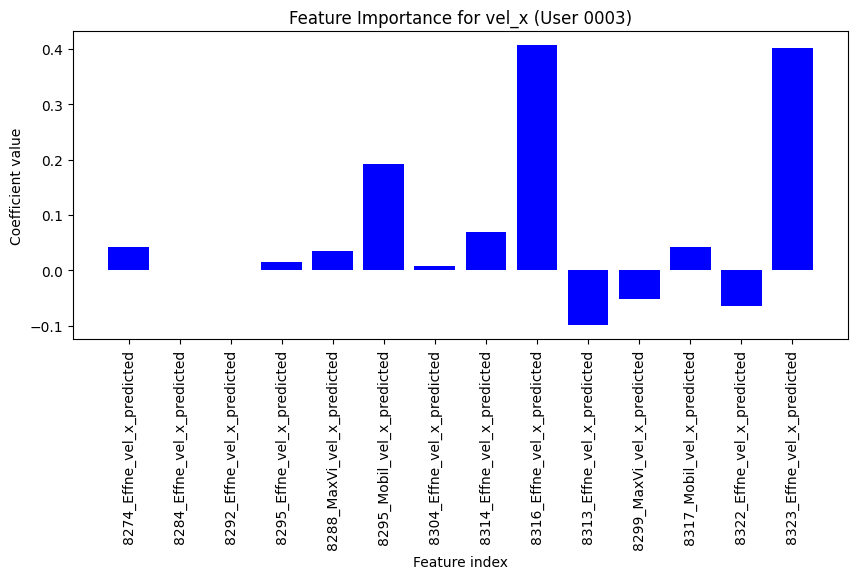

feature_names:['8274_Effne_vel_y_predicted', '8284_Effne_vel_y_predicted', '8292_Effne_vel_y_predicted', '8295_Effne_vel_y_predicted', '8288_MaxVi_vel_y_predicted', '8295_Mobil_vel_y_predicted', '8304_Effne_vel_y_predicted', '8314_Effne_vel_y_predicted', '8316_Effne_vel_y_predicted', '8313_Effne_vel_y_predicted', '8299_MaxVi_vel_y_predicted', '8317_Mobil_vel_y_predicted', '8322_Effne_vel_y_predicted', '8323_Effne_vel_y_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.743e+01, tolerance: 1.455e+00
  model = cd_fast.enet_coordinate_descent(


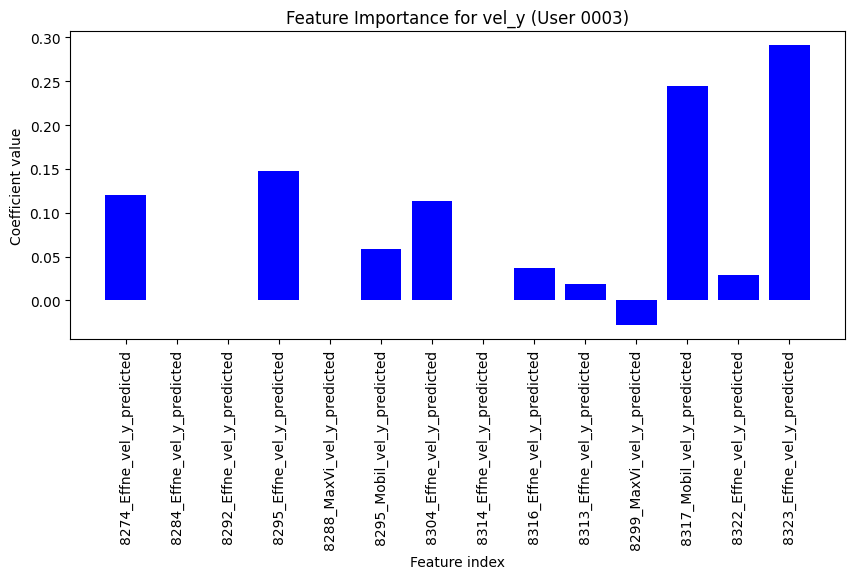

feature_names:['8274_Effne_vel_z_predicted', '8284_Effne_vel_z_predicted', '8292_Effne_vel_z_predicted', '8295_Effne_vel_z_predicted', '8288_MaxVi_vel_z_predicted', '8295_Mobil_vel_z_predicted', '8304_Effne_vel_z_predicted', '8314_Effne_vel_z_predicted', '8316_Effne_vel_z_predicted', '8313_Effne_vel_z_predicted', '8299_MaxVi_vel_z_predicted', '8317_Mobil_vel_z_predicted', '8322_Effne_vel_z_predicted', '8323_Effne_vel_z_predicted']


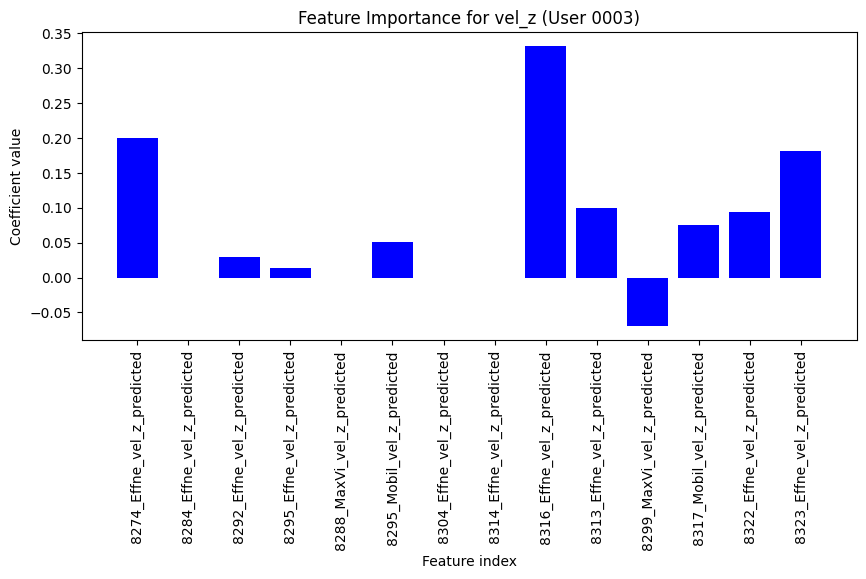

feature_names:['8274_Effne_vel_x_predicted', '8284_Effne_vel_x_predicted', '8292_Effne_vel_x_predicted', '8295_Effne_vel_x_predicted', '8288_MaxVi_vel_x_predicted', '8295_Mobil_vel_x_predicted', '8304_Effne_vel_x_predicted', '8314_Effne_vel_x_predicted', '8316_Effne_vel_x_predicted', '8313_Effne_vel_x_predicted', '8299_MaxVi_vel_x_predicted', '8317_Mobil_vel_x_predicted', '8322_Effne_vel_x_predicted', '8323_Effne_vel_x_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.475e+01, tolerance: 4.084e+00
  model = cd_fast.enet_coordinate_descent(


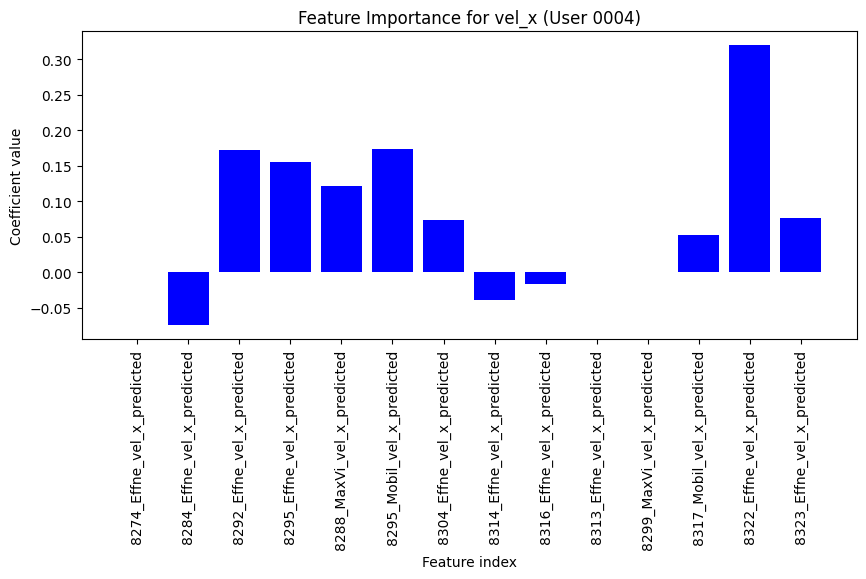

feature_names:['8274_Effne_vel_y_predicted', '8284_Effne_vel_y_predicted', '8292_Effne_vel_y_predicted', '8295_Effne_vel_y_predicted', '8288_MaxVi_vel_y_predicted', '8295_Mobil_vel_y_predicted', '8304_Effne_vel_y_predicted', '8314_Effne_vel_y_predicted', '8316_Effne_vel_y_predicted', '8313_Effne_vel_y_predicted', '8299_MaxVi_vel_y_predicted', '8317_Mobil_vel_y_predicted', '8322_Effne_vel_y_predicted', '8323_Effne_vel_y_predicted']


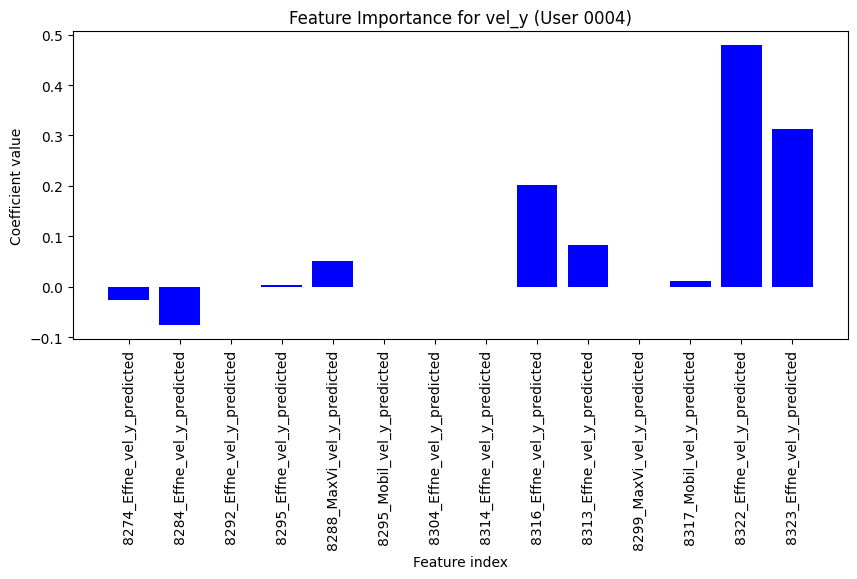

feature_names:['8274_Effne_vel_z_predicted', '8284_Effne_vel_z_predicted', '8292_Effne_vel_z_predicted', '8295_Effne_vel_z_predicted', '8288_MaxVi_vel_z_predicted', '8295_Mobil_vel_z_predicted', '8304_Effne_vel_z_predicted', '8314_Effne_vel_z_predicted', '8316_Effne_vel_z_predicted', '8313_Effne_vel_z_predicted', '8299_MaxVi_vel_z_predicted', '8317_Mobil_vel_z_predicted', '8322_Effne_vel_z_predicted', '8323_Effne_vel_z_predicted']


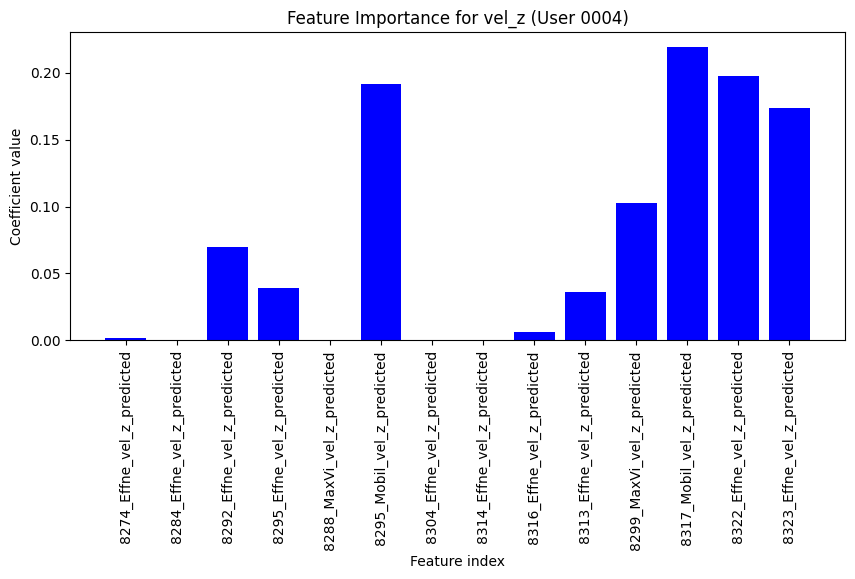

feature_names:['8274_Effne_vel_x_predicted', '8284_Effne_vel_x_predicted', '8292_Effne_vel_x_predicted', '8295_Effne_vel_x_predicted', '8288_MaxVi_vel_x_predicted', '8295_Mobil_vel_x_predicted', '8304_Effne_vel_x_predicted', '8314_Effne_vel_x_predicted', '8316_Effne_vel_x_predicted', '8313_Effne_vel_x_predicted', '8299_MaxVi_vel_x_predicted', '8317_Mobil_vel_x_predicted', '8322_Effne_vel_x_predicted', '8323_Effne_vel_x_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.237e+01, tolerance: 4.656e+00
  model = cd_fast.enet_coordinate_descent(


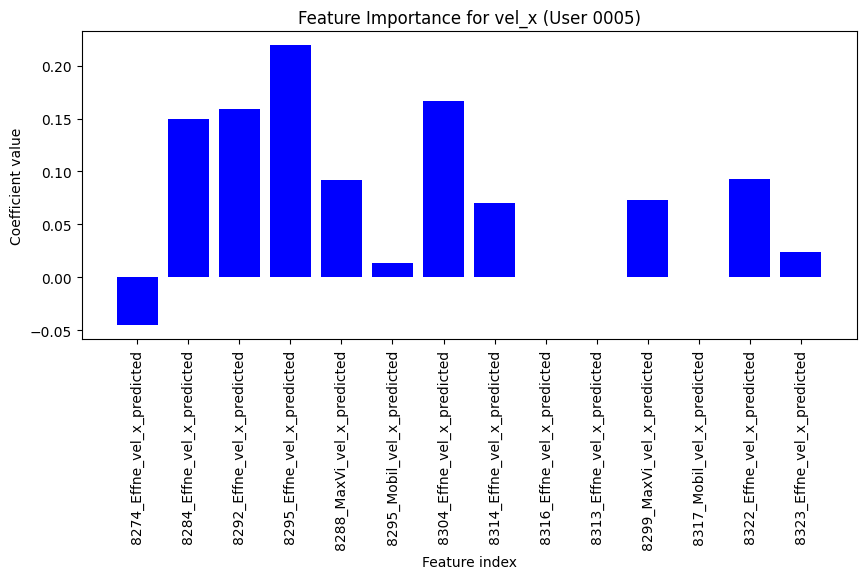

feature_names:['8274_Effne_vel_y_predicted', '8284_Effne_vel_y_predicted', '8292_Effne_vel_y_predicted', '8295_Effne_vel_y_predicted', '8288_MaxVi_vel_y_predicted', '8295_Mobil_vel_y_predicted', '8304_Effne_vel_y_predicted', '8314_Effne_vel_y_predicted', '8316_Effne_vel_y_predicted', '8313_Effne_vel_y_predicted', '8299_MaxVi_vel_y_predicted', '8317_Mobil_vel_y_predicted', '8322_Effne_vel_y_predicted', '8323_Effne_vel_y_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.883e+00, tolerance: 6.829e-01
  model = cd_fast.enet_coordinate_descent(


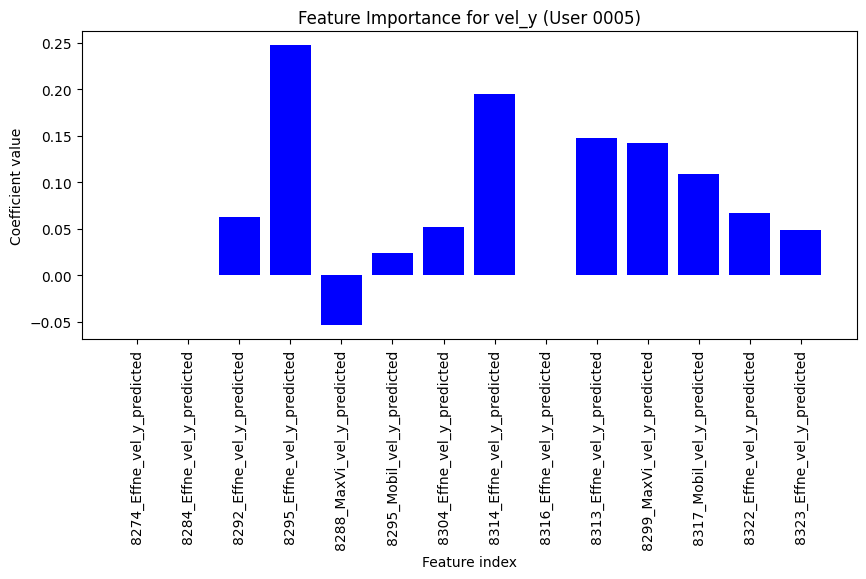

feature_names:['8274_Effne_vel_z_predicted', '8284_Effne_vel_z_predicted', '8292_Effne_vel_z_predicted', '8295_Effne_vel_z_predicted', '8288_MaxVi_vel_z_predicted', '8295_Mobil_vel_z_predicted', '8304_Effne_vel_z_predicted', '8314_Effne_vel_z_predicted', '8316_Effne_vel_z_predicted', '8313_Effne_vel_z_predicted', '8299_MaxVi_vel_z_predicted', '8317_Mobil_vel_z_predicted', '8322_Effne_vel_z_predicted', '8323_Effne_vel_z_predicted']


/home/user/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+00, tolerance: 5.638e-01
  model = cd_fast.enet_coordinate_descent(


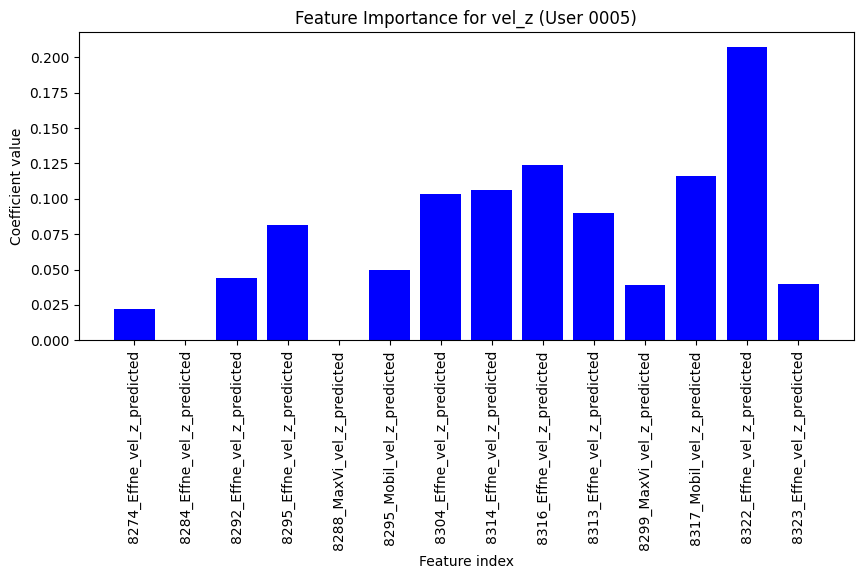

In [14]:
from sklearn.model_selection import train_test_split

# ユーザーごとの処理
test_results = []

for user_id in user_ids:
    train_features = []
    test_features = []
    feature_names = []
    train_features_dict = {'vel_x': [], 'vel_y': [], 'vel_z': []}
    test_features_dict = {'vel_x': [], 'vel_y': [], 'vel_z': []}
    feature_names_dict = {'vel_x': [], 'vel_y': [], 'vel_z': []}
    true_values = None
    
    # 各モデルのデータを結合
    for model in models:
        train_path = f"{output_folder}/{model}/train_{user_id}.csv"
        test_path = f"{output_folder}/{model}/test_{user_id}.csv"
        
        train_data = pd.read_csv(train_path)
        test_data = pd.read_csv(test_path)        

        # 各ターゲットに対応する予測列を抽出
        for target in ['vel_x', 'vel_y', 'vel_z']:
            for feature_name in train_data.columns:
                if 'predicted' in feature_name and target in feature_name:
                    model_prefix = model[:10]  # モデル名の最初の10文字
                    new_feature_name = f"{model_prefix}_{feature_name}"
                    train_features_dict[target].append(train_data[[feature_name]].rename(columns={feature_name: new_feature_name}))
                    test_features_dict[target].append(test_data[[feature_name]].rename(columns={feature_name: new_feature_name}))
                    feature_names_dict[target].append(new_feature_name)
        
        if true_values is None:
            true_values = train_data[['vel_x', 'vel_y', 'vel_z']]

    # トレーニングデータと検証データに分割
    for target in ['vel_x', 'vel_y', 'vel_z']:
        train_features = pd.concat(train_features_dict[target], axis=1)
        test_features = pd.concat(test_features_dict[target], axis=1)
        feature_names = feature_names_dict[target]
        print(f'feature_names:{feature_names}')

        X_train, X_valid, y_train, y_valid = train_test_split(train_features, true_values[target], test_size=0.2, random_state=42)
        
        # Lasso回帰モデル
        model = Lasso(alpha=alpha)
        model.fit(X_train, y_train)
        
        # テストデータでの予測
        predictions = model.predict(test_features)
        test_data[f'{target}_predicted_ens'] = predictions
        
        # 重要度の可視化（各速度成分）
        plt.figure(figsize=(10, 4))
        plt.bar(feature_names, model.coef_, color='b')
        plt.title(f'Feature Importance for {target} (User {user_id})')
        plt.ylabel('Coefficient value')
        plt.xlabel('Feature index')
        plt.xticks(rotation=90)
        plt.show()
    
    test_data['user_id'] = user_id
    test_data['timestamp'] = list(range(30)) * (len(test_data) // 30)
    test_data['trial'] = test_data.index // 30
    test_data = test_data[['timestamp', 'trial', 'vel_x_predicted_ens', 'vel_y_predicted_ens', 'vel_z_predicted_ens', 'user_id', 'vel_x', 'vel_y', 'vel_z']]
    test_results.append(test_data)

test_df = pd.concat(test_results, ignore_index=True)
test_df.to_csv(f"{os.path.join(output_folder, exp_name)}/ens_predictions.csv", index=False)


In [15]:
test_df

,timestamp,trial,vel_x_predicted_ens,vel_y_predicted_ens,vel_z_predicted_ens,user_id,vel_x,vel_y,vel_z
0,0,0,0.165778,0.256116,-0.795400,0001,0.000000,0.000000,0.000000
1,1,0,0.225795,0.288465,-0.897789,0001,0.000000,0.000000,0.000000
2,2,0,0.300745,0.322653,-0.985902,0001,0.000000,0.000000,0.000000
3,3,0,0.379313,0.365299,-1.076101,0001,0.000000,0.000000,0.000000
4,4,0,0.465109,0.405890,-1.163362,0001,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
47365,25,319,-0.120115,0.155226,0.235496,0005,-0.049611,-0.552450,0.165760
47366,26,319,-0.100834,0.147307,0.118671,0005,0.004203,-0.518994,0.052362
47367,27,319,-0.080453,0.140212,0.003809,0005,0.058942,-0.494789,-0.054487
47368,28,319,-0.059709,0.132460,-0.110387,0005,0.109464,-0.471038,-0.158647


In [16]:
# ref.0005を評価する場合（test0005で学習済の場合はスキップ）

# scores = []
# for user_id, group1 in test_df.groupby("user_id"):
#     if user_id == "0005":  # "0005" だけ評価
#         error_list = []
#         for trial, group2 in group1.groupby("trial"):
#             # numpyに変換して、transposeで(速度ベクトル, time)に変換すると元データに戻せる
#             y_t = group2[["vel_x", "vel_y", "vel_z"]].to_numpy()
#             # 予測用
#             y_p = group2[["vel_x_predicted_ens", "vel_y_predicted_ens", "vel_z_predicted_ens"]].to_numpy()
            
#             trial_rmse = np.sqrt(((y_t-y_p)**2).sum(axis=1).mean())
            
#             error_list.append(trial_rmse)
#         print(f"{user_id} rmse_3d mean: {np.mean(error_list)}")
#         scores.append(np.mean(error_list))
# print(f"RMSE_3D Mean: {np.mean(scores)}")
# Test0005_score = np.mean(scores)

## 提出ファイル作成

In [17]:
# 出力フォルダのパスを設定
output_path = os.path.join(output_folder, exp_name)

# user_id別にデータをフィルタリングし、CSVファイルに保存
for user_id in test_df['user_id'].unique():
    # ファイル名を生成
    file_name = f'test_{user_id}.csv'
    # user_idに合致するデータを抽出
    user_data = test_df[test_df['user_id'] == user_id][["vel_x_predicted_ens", "vel_y_predicted_ens", "vel_z_predicted_ens", 'vel_x', 'vel_y', 'vel_z']]
    # CSVに保存
    user_data.to_csv(os.path.join(output_path, file_name), index=False)

## 予測結果の提出。

In [18]:
# サンプル提出ファイルを確認します
with open("dataset/sample_submit.json") as r:
    sample_submit = json.load(r)

In [19]:
# キーの確認
print(sample_submit.keys())

dict_keys(['sub1', 'sub2', 'sub3', 'sub4'])


In [20]:
for i, (user_id, group1) in enumerate(test_df.groupby("user_id")):
    if user_id != "0005":  # "0005" をスキップ
        print(f'i:{i}, user_id:{user_id}')
        sub_dict = {}
        for trial, group2 in group1.groupby("trial"):
            y_pred = group2[["vel_x_predicted_ens", "vel_y_predicted_ens", "vel_z_predicted_ens"]].to_numpy()
            sub_dict[f"trial{trial+1}"] = y_pred.tolist()
        sample_submit[f"sub{i+1}"] = sub_dict

i:0, user_id:0001
i:1, user_id:0002
i:2, user_id:0003
i:3, user_id:0004


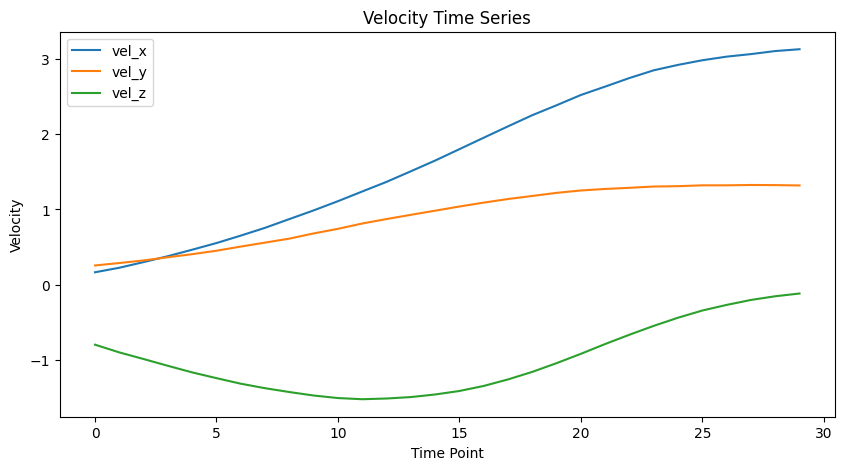

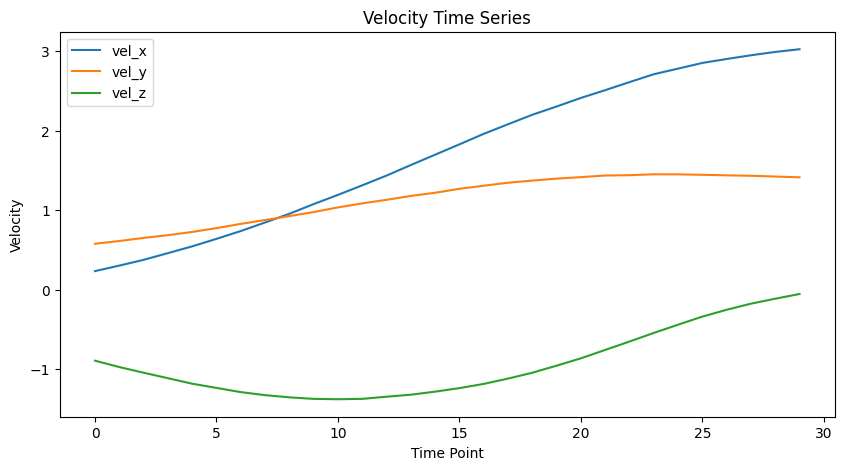

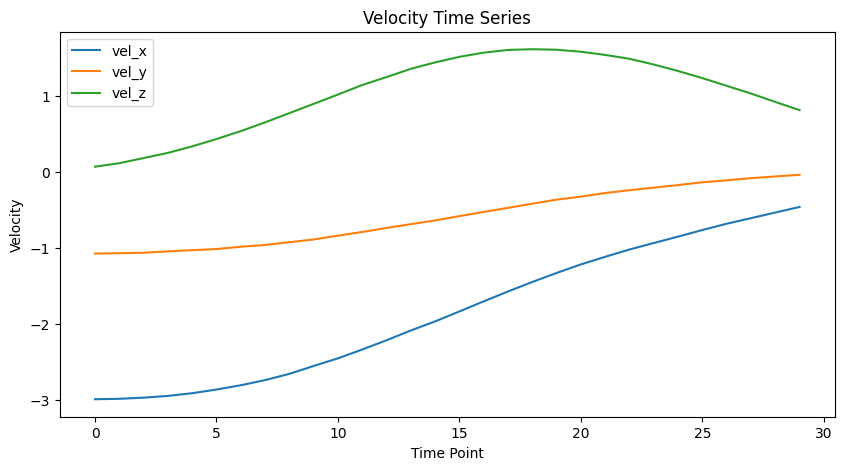

In [21]:
# データの確認

# 各軸のデータを抽出
trial_num = 'trial1'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

# 各軸のデータを抽出
trial_num = 'trial2'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

# 各軸のデータを抽出
trial_num = 'trial3'
vel_x = [item[0] for item in sample_submit["sub1"][trial_num]]
vel_y = [item[1] for item in sample_submit["sub1"][trial_num]]
vel_z = [item[2] for item in sample_submit["sub1"][trial_num]]

# プロット
plt.figure(figsize=(10, 5))
plt.plot(vel_x, label="vel_x")
plt.plot(vel_y, label="vel_y")
plt.plot(vel_z, label="vel_z")
plt.legend()
plt.title("Velocity Time Series")
plt.xlabel("Time Point")
plt.ylabel("Velocity")
plt.show()

In [22]:
# 長さの確認をします
print(sample_submit.keys())
for k in sample_submit.keys():
    print(k, len(sample_submit[k]))

dict_keys(['sub1', 'sub2', 'sub3', 'sub4'])
sub1 319
sub2 300
sub3 320
sub4 320


In [23]:
print(sample_submit)

{'sub1': {'trial1': [[0.16577762485850323, 0.25611558013077135, -0.7954001130136528], [0.22579456047315924, 0.2884651824654936, -0.8977888103869744], [0.3007447638104972, 0.32265308508327384, -0.9859015643747496], [0.37931314514372205, 0.3652986960919108, -1.0761012552301477], [0.46510904837285005, 0.40588981830305443, -1.1633621407465862], [0.553653203852037, 0.45183411410207447, -1.2397605311886386], [0.6523787321349102, 0.5069106803141042, -1.3134463150476934], [0.7558319576300897, 0.5596025225038767, -1.373229160592577], [0.8717867393426616, 0.6123312574969463, -1.4241313727360139], [0.9871034135504543, 0.6812331074320135, -1.4703787723251467], [1.1094135589840792, 0.7424781190001409, -1.5039530749972678], [1.2380527152412022, 0.8129368688994222, -1.519430835859243], [1.3658066356940013, 0.872424646105825, -1.5098451169786578], [1.5063268030501196, 0.9282091329837802, -1.4908228148982292], [1.648634838334209, 0.9832301557424453, -1.4564367981743798], [1.7999494326823882, 1.03853755

In [24]:
# 予測結果の中身に問題がないことを確認
for k in sample_submit.keys():
    for kk in sample_submit[k].keys():
        # (30, 3)の形でなければ例外
        if np.array(sample_submit[k][kk]).shape != (30, 3):
            print(f"invalid: {k} {kk}")

In [25]:
# フォーマットされたCVスコアをファイル名に使用
submission_filename = f"submission.json"
submission_path = os.path.join(output_folder, exp_name, submission_filename)

# 提出ファイルとして保存
with open(submission_path, "w") as f:
    json.dump(sample_submit, f)

print(f"Submission file saved as {submission_path}")

Submission file saved as output/9045_Stacking/submission.json
